### Classifiers and Regressors

#### Classifiers and Regressors help cells

In [1]:
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

In [2]:
# datasets: list of datasets
# make_categorical_data: transform numeric -1, 0, 1 data to categorical data, for each dimension 2 new ones, 
#       one with either SIMP/NOT_SIMP and one for ABSTAIN
def load_data(datasets, make_categorical_data):
    KAT = ''
    if make_categorical_data:
        KAT = '_KAT'

    data_merged = []
    labels = []

    for d_s in datasets:
        simp_path = f"/workspace/datasets/ds_labels/{d_s}_simp_labels.pkl"        
        src_path = f"/workspace/datasets/ds_labels/{d_s}_src_labels.pkl"  

        simp_labels = pickle.load(open(simp_path, "rb"))
        src_labels = pickle.load(open(src_path, "rb")) 

        for entry in simp_labels:
            if make_categorical_data:
                new_ent = []
                for e in entry:
                    if e == -1:
                        new_ent.append(0)
                        new_ent.append(1)

                    if e == 0:
                        new_ent.append(1)
                        new_ent.append(0)

                    if e == 1:
                        new_ent.append(1)
                        new_ent.append(0)
                    
                data_merged.append(new_ent)
            else:
                data_merged.append(entry.tolist())

        for entry in src_labels:
            if make_categorical_data:
                new_ent = []
                for e in entry:
                    if e == -1:
                        new_ent.append(0)
                        new_ent.append(1)

                    if e == 0:
                        new_ent.append(1)
                        new_ent.append(0)

                    if e == 1:
                        new_ent.append(1)
                        new_ent.append(0)

                data_merged.append(new_ent)
            else:
                data_merged.append(entry.tolist())

        curr_lab = [0] * len(simp_labels) + [1] * len(simp_labels)
        labels = labels + curr_lab

    X, y = shuffle(data_merged, labels, random_state=42)
    return X, y, KAT

In [3]:
clf_gb = GradientBoostingClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)

clfs = {'gb': clf_gb, 'rf': clf_rf}

reg_gb = GradientBoostingRegressor(random_state=42)
reg_rf = RandomForestRegressor(random_state=42)
reg_mlp = MLPRegressor(random_state=42)

regs = {'reg_gb': reg_gb, 'reg_rf': reg_rf, 'reg_mlp': reg_mlp}

In [4]:
def run_classifiers(run, X, y, run_type):
    if run:
        output = ''
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        for clf in clfs:
            cv_scores = cross_val_score(clfs[clf], X, y, cv=kfold)
            output += clf + ' (' + run_type + ') : '
            output += str(sum(cv_scores)/len(cv_scores)) + '\n'
            output += str(cv_scores) + '\n___\n'
        return output, sum(cv_scores)/len(cv_scores)
    return '', 0

def run_regressors(run, X, y):
    if run:
        output = ''
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        for reg in regs:
            cv_scores = cross_val_score(regs[reg], X, y, cv=kfold)
            output += reg + ': '
            output += str(sum(cv_scores)/len(cv_scores)) + '\n'
            output += str(cv_scores) + '\n___\n'
        return output, sum(cv_scores)/len(cv_scores)
    return '', 0

#### Classifiers and Regressors run

In [18]:
datasets = ['Wiki-Manual'] #'britannica', 'ASSET', 'MTurkSF', 'Wiki-Manual','eval'

X, y, KAT = load_data(datasets, make_categorical_data=True)
print(run_classifiers(True, X, y, 'vanilla' + KAT)[0])
print(run_regressors(False, X, y)[0])

gb (vanilla_KAT) : 0.44497178966373285
[0.42180095 0.39810427 0.47393365 0.46445498 0.47867299 0.4549763
 0.4028436  0.46445498 0.5047619  0.38571429]
___
rf (vanilla_KAT) : 0.31926427443015115
[0.3507109  0.33649289 0.3507109  0.2985782  0.31753555 0.30331754
 0.26540284 0.32227488 0.35238095 0.2952381 ]
___




### Feature Selection

#### Feature Selection help cells

In [6]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
from tqdm import tqdm

In [7]:
# naive_categorical_tuples: if using the naive_feature_selection_count and make_categorical_data and 1 dim of the 2 belonging together is chosen,
#       should the two dimensions both be considered together in the resulting dimensions
def run_naive_feature_selection(X, y, k, naive_categorical_tuples):    
    dims_to_include = []
    
    # only include dimensions where values are the most different 
    for lf_dim in range(len(X[0])):
        sum_i_src = 0
        sum_i_simp = 0
        for d_p in range(len(X)):
            if y[d_p] == 0:
                sum_i_simp += X[d_p][lf_dim]
            else:
                sum_i_src += X[d_p][lf_dim]

        dist = abs(sum_i_simp - sum_i_src)

        if len(dims_to_include) < k:
            dims_to_include.append((lf_dim, dist))
        else:
            replace_cand_dist = -1
            replace_cand_dim = -1
            # find dim with lowest dist
            for inc_dim in range(len(dims_to_include)):
                if dims_to_include[inc_dim][1] < dist and (replace_cand_dist == -1 or replace_cand_dist > dims_to_include[inc_dim][1]):
                    replace_cand_dim = inc_dim
                    replace_cand_dist = dims_to_include[inc_dim][1]
                        
            # replace it
            if replace_cand_dim > -1:
                dims_to_include[replace_cand_dim] = (lf_dim, dist)

    X_naive = []
    for d_p in range(len(X)):
        new_dp = []
        all_bases = []
        for inc_dims in dims_to_include:
            if naive_categorical_tuples:
                # check if dim has already been included
                base = int(inc_dims[0] / 2)
                if base not in all_bases:
                    all_bases.append(base)
                    base_dim = 2 * base

                    new_dp.append(X[d_p][base_dim])
                    new_dp.append(X[d_p][base_dim + 1])
            else:
                new_dp.append(X[d_p][inc_dims[0]])
        X_naive.append(new_dp)
    return X_naive

def run_chi2(X, y, k):
    X_chi2 = SelectKBest(chi2, k=k).fit_transform(X, y)
    return X_chi2

def run_mean_importance(X, y, k):
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    feature_importances = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = np.take(X, train_index, axis=0), np.take(X, test_index, axis=0)
        y_train, y_test = np.take(y, train_index), np.take(y, test_index)

        clf_gb.fit(X_train, y_train)

        perm_importance = permutation_importance(clf_gb, X_test, y_test)
        feature_importances.append(perm_importance.importances_mean)

    mean_importance = np.mean(feature_importances, axis=0)
    sorted_indices = np.argsort(mean_importance)[::-1]
    top_k_indices = sorted_indices[:k]

    X_mean_importance = []

    for dp in X:
        new_dp = []
        for dim in top_k_indices:
            new_dp.append(dp[dim])
        X_mean_importance.append(new_dp)
    return X_mean_importance

def run_random(X, y, k):
    dims_to_include = shuffle(range(0, len(X[0]) - 1), random_state=42)[:k]

    X_random = []

    for d_p in range(len(X)):
        new_dp = []
        for inc_dims in dims_to_include:
            new_dp.append(X[d_p][inc_dims])
        X_random.append(new_dp)
    return X_random

#### Feature Selection run

In [8]:
all_res = []

for i in tqdm(range(10, len(X[0])-1, 10)):
    num_cat = i
    
    if len(X[0]) < num_cat:
        print('Error: Number of categories smaller than dimensions of input data!')
        exit()

    X_naive = run_naive_feature_selection(X, y, num_cat, False)
    X_chi2 = run_chi2(X, y, num_cat)
    X_mean_importance = run_mean_importance(X, y, num_cat)
    X_random = run_random(X, y, num_cat)

    naive_score = run_classifiers(True, X_naive, y, 'naive' + KAT + '_' + str(num_cat))[1]
    chi_score = run_classifiers(True, X_chi2, y, 'chi2' + KAT + '_' + str(num_cat))[1]
    meanImp_score = run_classifiers(True, X_mean_importance, y, 'mean importance' + KAT + '_' + str(num_cat))[1]
    rand_score = run_classifiers(True, X_random, y, 'random' + KAT + '_' + str(num_cat))[1]

    all_res.append([naive_score, chi_score, meanImp_score, rand_score])

100%|██████████| 65/65 [23:58<00:00, 22.13s/it]


#### Feature Selection Visualisation

In [9]:
!pip install seaborn

In [10]:
import pickle as pkl
import seaborn as sns

In [11]:
newly_generated = False

if newly_generated:
    with open('/workspace/datasets/performance_of_features/' + datasets[0] + '_performance_of_feature_selection.pkl', 'wb') as f:
        pkl.dump(all_res, f)
else:
    all_res = pd.read_pickle('/workspace/datasets/performance_of_features/' + datasets[0] + '_performance_of_feature_selection.pkl')


[Text(0.5, 1.0, 'Wiki-Manual'),
 Text(0.5, 0, 'Number of Dimensions'),
 Text(0, 0.5, 'Mean Accuracy')]

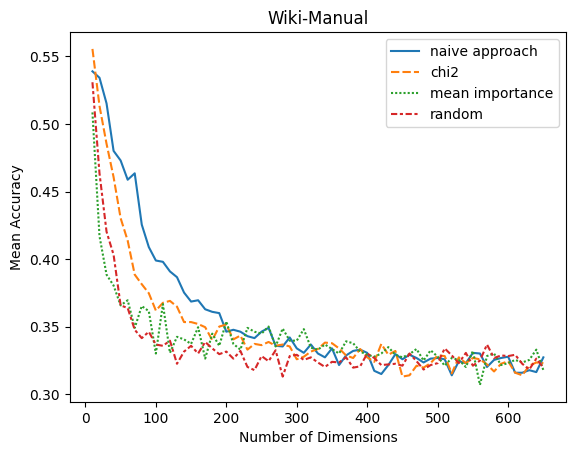

In [20]:
df = pd.DataFrame(all_res, index=range(10, len(X[0]), 10), columns=['naive approach', 'chi2', 'mean importance', 'random'])
sns.lineplot(data=df).set(title=datasets[0], xlabel='Number of Dimensions', ylabel='Mean Accuracy')